# 04 project

# Computer Says No


### Импорт библиотек

In [1100]:
import warnings
from pandas import Series
import pandas as pd
import numpy as np
import collections

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score


import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore")  # Убирает некритические сообщения

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


## Предобработка

In [1101]:
# Печать основных метрик (асс f1)
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')
    
# Определение межквартильных расстояний для оценки выбросов

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression (ROC AUC = %0.5f)' % roc_auc)
    
    # Подписи осей, легенда.
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(loc='lower right')

## Анализ датасета

In [1102]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [1103]:
# Показывать больше колонок
pd.set_option('display.max_columns', None)

In [1104]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


In [1105]:
print('тест:', train.shape, 'трэйн:', test.shape, 'пример сабмишна:', sample_submission.shape)

тест: (73799, 19) трэйн: (36349, 18) пример сабмишна: (24354, 2)


Получается, размерность финального сабмишна должна быть (36349, 2) - для контроля.

In [1106]:
# Не знаю, нужно или нет, - для воспроизводимости, по примеру прошлого проекта
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [1107]:
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [1108]:
test.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport'],
      dtype='object')

## Очистка данных

> ### Пропуски

In [1109]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

Немного пропусков есть только в столбце education.
Построим гистограммы для education

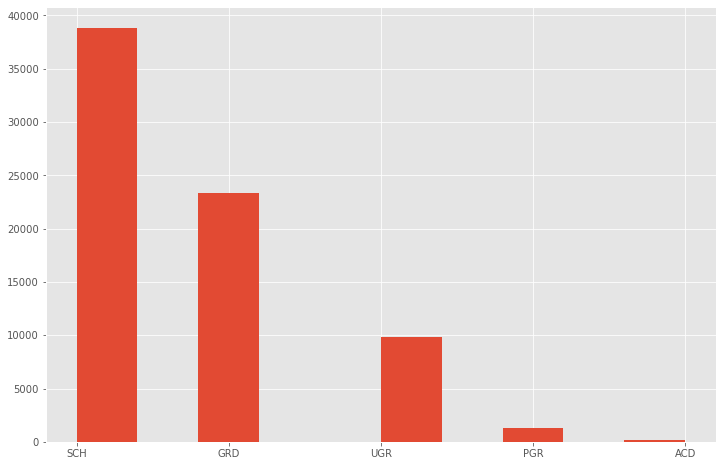

In [1110]:
train['education'].hist()

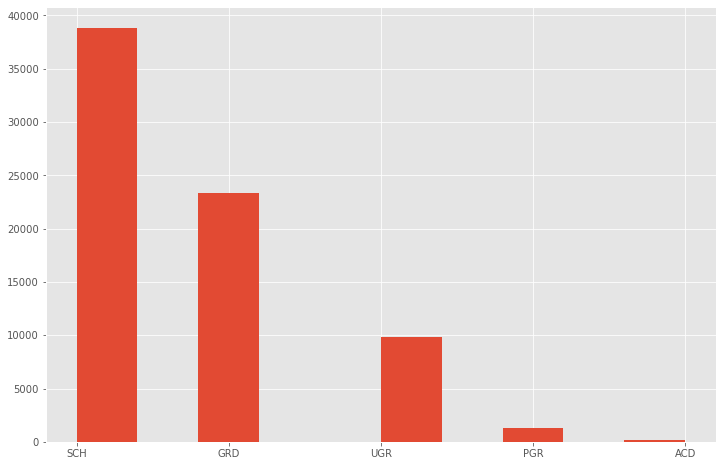

In [1111]:
train['education'].hist()

Видно, что в обоих частях датасета, больше всего людей относятся к  категории SCH.
Заполним пропуски наиболее часто встречающимся значением.

In [1112]:
train.education.fillna('SCH', inplace = True)
test.education.fillna('SCH', inplace = True)

In [1113]:
# проверим заполнение
train.education.isnull().sum(), test.education.isnull().sum()

(0, 0)

## Анализ признаков

In [1114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73799 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [1115]:
# Сконветируем даты
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)
print(train.app_date.head(5))
print(test.app_date.head(5))

# Создадим признаки на основе даты
current_date = pd.to_datetime('25MAR2021')
train['days'] = (current_date - train.app_date).dt.days
test['days'] = (current_date - test.app_date).dt.days

train['month'] = train['app_date'].dt.month
test['month'] = test['app_date'].dt.month


train['weekend'] = train['app_date'].dt.weekday
test['weekend'] = test['app_date'].dt.weekday

train['weekend'] = train['weekend'].apply(lambda x: 1 if x >= 5 else 0)
test['weekend'] = test['weekend'].apply(lambda x: 1 if x >= 5 else 0)


0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]
0   2014-03-22
1   2014-01-24
2   2014-03-23
3   2014-02-03
4   2014-02-04
Name: app_date, dtype: datetime64[ns]


In [1116]:
train.first_time.value_counts()

3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64

### Разделим признаки на три группы: бинарные, категориальные, численные

In [1117]:
# Бинарные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# Категориальные
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating', 'month']

# Численные
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'weekend', 'month', 'days'] #days 'bki_reg'

Посмотрим на целевую переменную. Распределение заёмщиков явно неравномерное, недефолтных клиентов заметно больше.

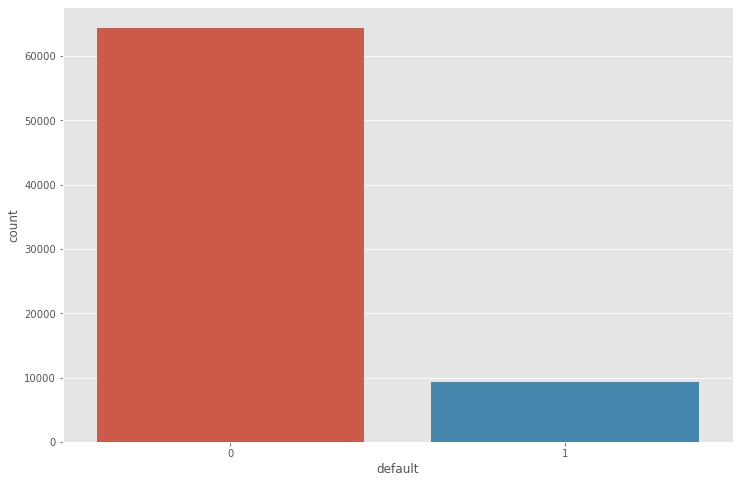

In [1118]:
sns.countplot(train['default'])

In [1119]:
train['default'].value_counts()
# Очевидно что выборка распределена неравномерно

0    64427
1     9372
Name: default, dtype: int64

In [1120]:
# Применяем oversampling для устранения дисбаланса
train_0 = train.query('default == 0')
train_1 = train.query('default == 1')
koeff = int(len(train_0)/len(train_1))
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True)  # объединяем

In [1121]:
train['default'].value_counts()

1    65604
0    64427
Name: default, dtype: int64

## Числовые признаки

посмотрим boxplot числовых признаков

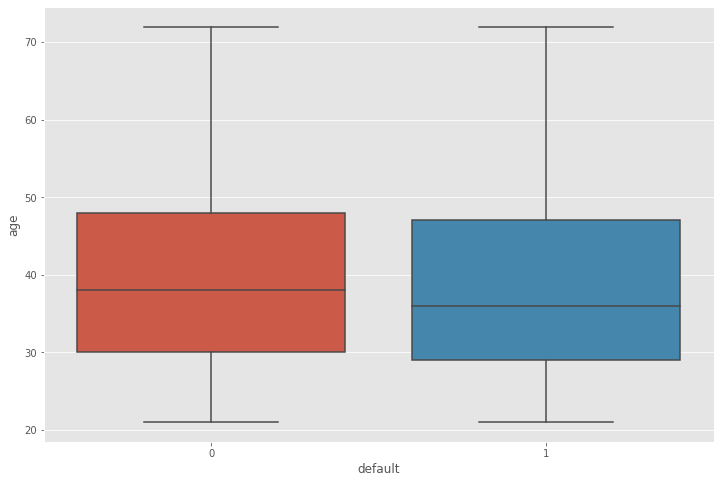

In [1122]:
sns.boxplot(x=train.default, y=train.age)
# выбросов нет

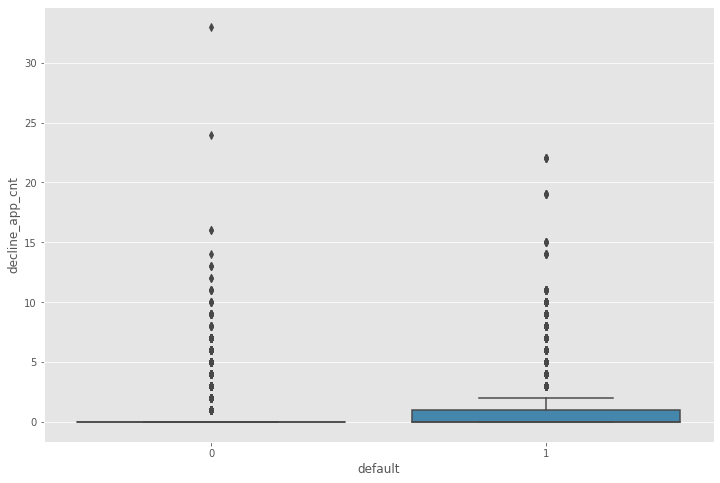

In [1123]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных.

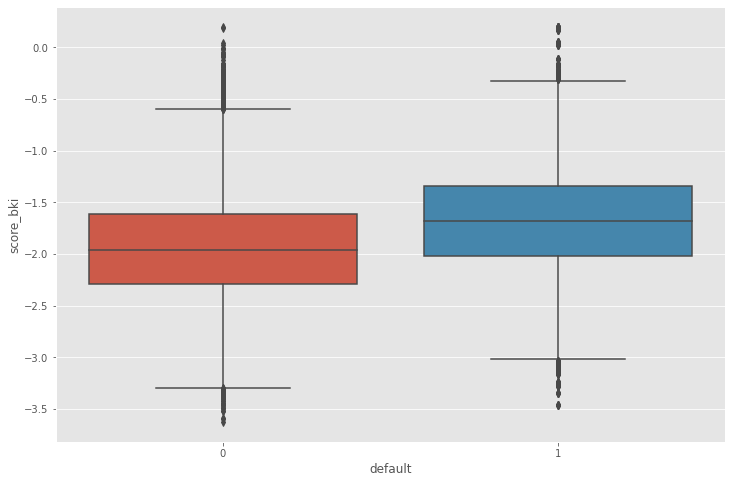

In [1124]:
sns.boxplot(x=train.default, y=train.score_bki)

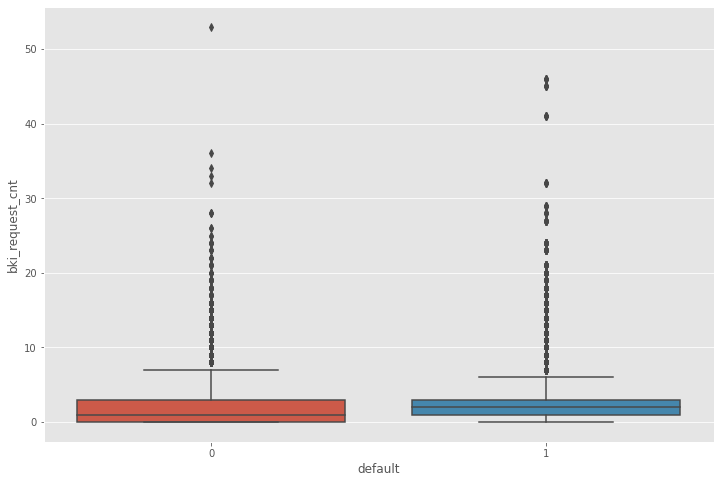

In [1125]:
sns.boxplot(x=train.default, y=train.bki_request_cnt)

Средний показатель числа запросов в БКИ у дефолтных клиентов выше. 

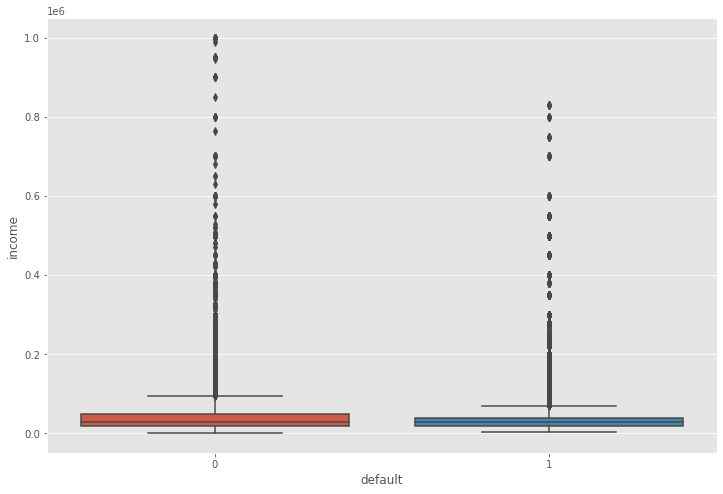

In [1126]:
sns.boxplot(x=train.default, y=train.income)

Кредиты чаще выдают тем, у кого уровень дохода выше. Выбросы есть.

## Убираем выбросы

In [1127]:
# убираем выбросы в численных столбцах
num_cols_1 = ['bki_request_cnt', 'score_bki']
for colname in num_cols_1:
    d = outliers_iqr(train[colname])
    train = train.loc[train[colname].between(d[0], d[1])]

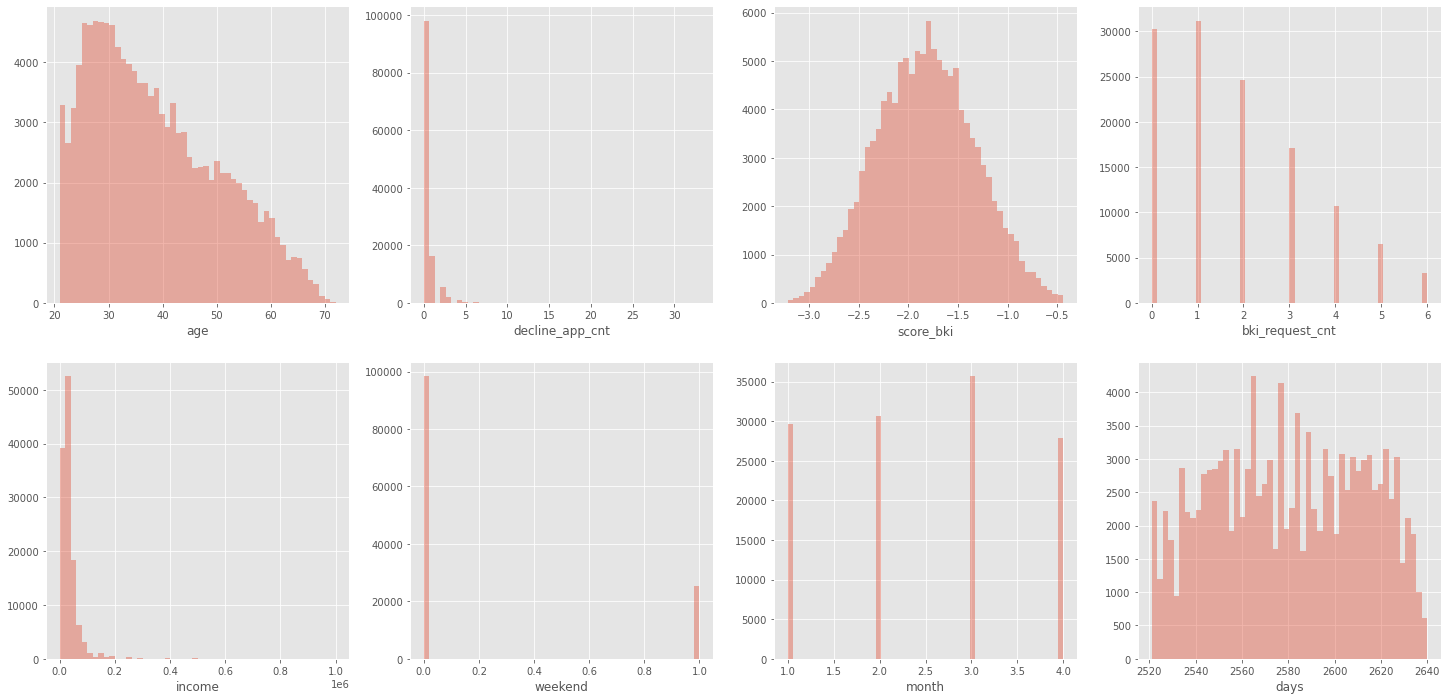

In [1128]:
# Построим графики распределения численных переменных
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [1129]:
# Прологарифмируем переменные со смещенным распределением

num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']


for i in num_cols_log:
    train[i] = np.log(train[i] + 1)

In [1130]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)

### Преобразование бинарных и категориальных переменных
Преобразуем бинарные переменные при помощи класса LabelEncoder

In [1131]:
label_encoder = LabelEncoder()

# mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
# print(dict(enumerate(label_encoder.classes_)))

In [1132]:
for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])


# проверим
display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days,month,weekend
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,2609,2,1
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,2570,3,0
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,2609,2,1
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,2618,1,0
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,2533,4,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days,month,weekend
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,2560,3,1
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,2617,1,0
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,2559,3,1
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,2607,2,0
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,2606,2,0


In [1133]:
train.sna.value_counts()

1    71515
4    25354
2    19233
3     7634
Name: sna, dtype: int64

In [1134]:
# Генерируем новые признаки (в том числе искусственные) - проверяем как они влияют на модель

# Сколько отклонили заявок с момента первого обращения
train['history_neg'] = train['first_time']/(train['decline_app_cnt']+1)
test['history_neg'] = test['first_time']/(test['decline_app_cnt']+1)
num_cols.append('history_neg')

# Отношение периода с первого обращения к возрасту
train['history_norm'] = train['first_time']/(train['age']+1)
test['history_norm'] = test['first_time']/(test['age']+1)
#num_cols.append('history_norm')

# 
train['envir_2'] = train['income']*train['region_rating']/(train['sna'])
test['envir_2'] = test['income']*test['region_rating']/(test['sna'])
#num_cols.append('envir_2')

# 
train['bki_age_reg'] = (train['score_bki']/(train['age']+1))**train['region_rating']
test['bki_age_reg'] = (test['score_bki']/(test['age']+1))**test['region_rating']
num_cols.append('bki_age_reg')

#
train['score_rel'] = (train['score_bki']*train['age'])**train['sna']
test['score_rel'] = (test['score_bki']*test['age'])**test['sna']
num_cols.append('score_rel')

#
train['score_pas'] = (train['score_bki']*train['age'])**train['foreign_passport']
test['score_pas'] = (test['score_bki']*test['age'])**test['foreign_passport']
num_cols.append('score_pas')

'''
train['req_rel'] = train['bki_request_cnt']**train['score_rel']
test['req_rel'] = test['bki_request_cnt']**test['score_rel']
num_cols.append('req_rel')'''

"\ntrain['req_rel'] = train['bki_request_cnt']**train['score_rel']\ntest['req_rel'] = test['bki_request_cnt']**test['score_rel']\nnum_cols.append('req_rel')"

In [1135]:
corr = train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,age,decline_app_cnt,score_bki,bki_request_cnt,income,weekend,month,days,history_neg,bki_age_reg,score_rel,score_pas
age,1.000,-0.151,-0.109,0.047,-0.102,-0.024,0.018,-0.021,0.143,-0.002,0.126,-0.000
decline_app_cnt,-0.151,1.000,0.212,0.077,-0.023,0.013,-0.019,0.018,-0.495,0.001,-0.041,0.058
score_bki,-0.109,0.212,1.000,0.108,-0.018,0.005,-0.055,0.055,-0.159,-0.030,-0.250,0.121
bki_request_cnt,0.047,0.077,0.108,1.000,0.058,0.012,0.004,-0.006,-0.029,-0.009,-0.016,0.019
income,-0.102,-0.023,-0.018,0.058,1.000,-0.014,0.008,-0.007,0.140,-0.010,-0.094,-0.248
weekend,-0.024,0.013,0.005,0.012,-0.014,1.000,-0.002,0.018,-0.019,-0.001,0.006,0.011
month,0.018,-0.019,-0.055,0.004,0.008,-0.002,1.000,-0.964,0.023,-0.006,0.013,0.002
days,-0.021,0.018,0.055,-0.006,-0.007,0.018,-0.964,1.000,-0.021,0.007,-0.013,-0.000
history_neg,0.143,-0.495,-0.159,-0.029,0.140,-0.019,0.023,-0.021,1.000,-0.005,-0.226,-0.192
bki_age_reg,-0.002,0.001,-0.030,-0.009,-0.010,-0.001,-0.006,0.007,-0.005,1.000,0.039,0.005


Высокой корреляции между признаками не наблюдается, за исключением искусственно созданного bki_age_rate и составляющих его признаков. Но корреляция не настолько высока (меньше 0.7), чтобы исключать наш признак из анализа.

### Преобразуем категориальные переменные в числовые при помощи dummies и OneHotEncoder

In [1136]:
train = pd.get_dummies(train, columns=['education'])
train = pd.get_dummies(train, columns=['region_rating'])
train.sample(5)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,home_address,work_address,income,sna,first_time,foreign_passport,default,days,month,weekend,history_neg,history_norm,envir_2,bki_age_reg,score_rel,score_pas,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80
83078,57459,2014-03-06,0,3.433987,0,0,1.098612,1,-1.521651,0.000000,1,2,10.085851,1,3,0,1,2576,3,0,1.429516,0.676592,504.292539,5.970748e-24,-5.225330,1.0,0,0,0,1,0,0,0,0,1,0,0,0
47554,103113,2014-04-21,0,3.806662,0,0,0.000000,0,-1.456282,0.000000,2,3,10.236418,1,3,0,0,2530,4,0,3.000000,0.624134,716.549247,4.990259e-37,-5.543573,1.0,0,0,0,1,0,0,0,0,0,0,1,0
3383,31685,2014-02-07,1,3.091042,0,0,0.000000,0,-2.233557,0.000000,2,3,10.518700,1,3,0,0,2603,2,0,3.000000,0.733309,841.496017,9.398330e-22,-6.904021,1.0,0,0,0,1,0,0,0,0,0,0,0,1
54037,105415,2014-04-24,0,3.663562,0,0,0.000000,0,-1.491828,1.945910,1,2,10.126671,1,4,0,0,2527,4,0,4.000000,0.857714,810.133688,2.512398e-40,-5.465405,1.0,0,0,0,1,0,0,0,0,0,0,0,1
71809,44570,2014-02-21,0,3.951244,0,0,0.000000,0,-2.353052,1.098612,2,3,10.126671,4,3,0,0,2589,2,0,3.000000,0.605908,151.900067,4.121264e-20,7472.418520,1.0,0,0,0,1,0,0,0,0,0,1,0,0


In [1137]:
test = pd.get_dummies(test, columns=['education'])
test = pd.get_dummies(test, columns=['region_rating'])
#test.head()

In [1138]:
cat_cols = ['home_address', 'work_address', 'sna', 'first_time', 'education_ACD',
    'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
    'region_rating_20', 'region_rating_30', 'region_rating_40',
    'region_rating_50', 'region_rating_60', 'region_rating_70',
    'region_rating_80','month']

x_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse=False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(123736, 42)
(36349, 42)


In [1139]:
test.head(2)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,home_address,work_address,income,sna,first_time,foreign_passport,days,month,weekend,history_neg,history_norm,envir_2,bki_age_reg,score_rel,score_pas,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80
0,74835,2014-03-22,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,1,2,10.819798,1,4,0,2560,3,1,4.000000,0.908844,540.989914,4.372826e-15,-7.727125,1.0,0,1,0,0,0,0,0,0,1,0,0,0
1,17527,2014-01-24,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,1,2,8.517393,4,3,0,2617,1,0,1.074591,0.639812,106.467415,2.105520e-25,949.998397,1.0,0,0,0,1,0,0,0,0,1,0,0,0


### Значимость числовых переменных

Text(0.5, 0, 'F-value')

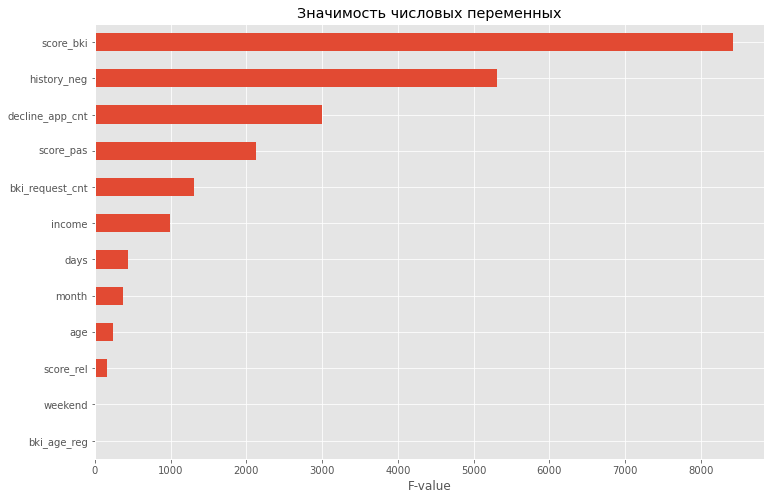

In [1140]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость числовых переменных')
plt.xlabel('F-value')

### Значимость бинарных и категориальных переменных

Text(0.5, 1.0, 'Значимость бинарных переменных')

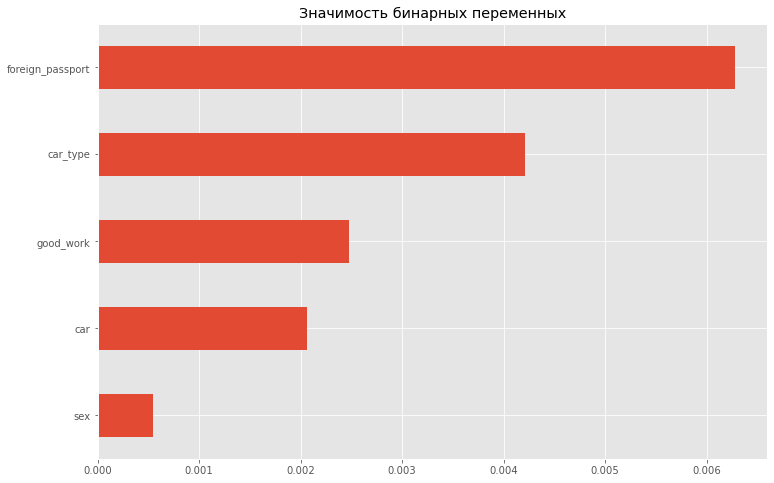

In [1141]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'], discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных переменных')

Видим, что наличие загран паспорта и флаг иномарки являются наиболее значимыми признаками. Пол - наименее. НО из этого набора исключать ничего не будем.

Text(0.5, 1.0, 'Значимость категориальных признаков')

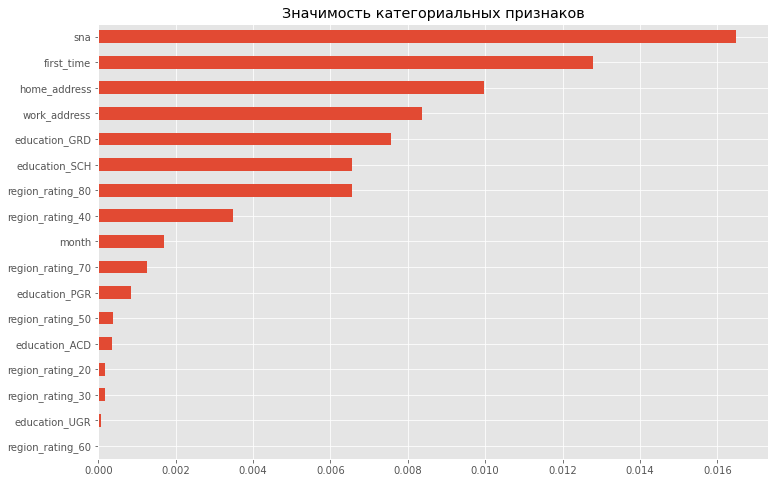

In [1142]:
# Значимость категориальных признаков

imp_cat = pd.Series(mutual_info_classif(train[cat_cols], train['default'],
                    discrete_features=True), index=train[cat_cols].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категориальных признаков')

### Подготовка данных к машинному обучению

In [1143]:
poly = PolynomialFeatures(2)

x_p = poly.fit_transform(train[num_cols].values)
y_p = poly.fit_transform(test[num_cols].values)

In [1144]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(x_p)
X_num.shape

(123736, 91)

In [1145]:
Y_num = StandardScaler().fit_transform(y_p)
Y_num.shape

(36349, 91)

Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство.

Разделим признаки и целевую переменную.

In [1146]:
X = np.hstack([X_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([Y_num, test[bin_cols].values, y_cat])

In [1147]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED, shuffle=True)

### Подбор гиперпараметров (регуляризация)

In [1148]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 1291.5496650148827


### Обучение и метрики

In [1149]:
# Обучим модель

model = LogisticRegression(penalty='l2', C = 1291.5496650148827, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=21.544346900318832, max_iter=1000)

In [1150]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]

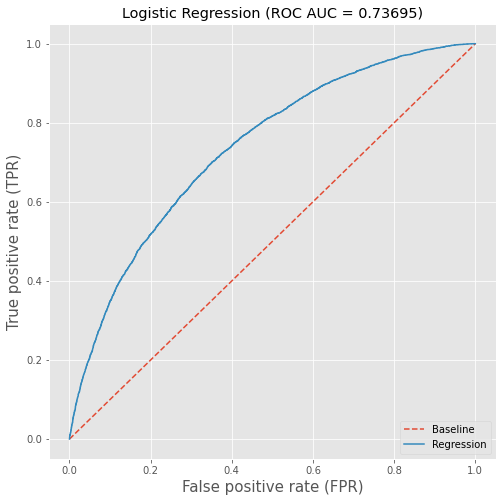

In [1151]:
calc_and_plot_roc(y_test, probs)

In [1152]:
Y_predicted = model.predict(X_test)
print_logisitc_metrics(y_test, Y_predicted)

acc = 0.67 F1-score = 0.67


In [1153]:
# confusion matrix
conmx = confusion_matrix(y_test, Y_predicted)
conmx

array([[8342, 4179],
       [3919, 8308]])

In [1154]:
model = LogisticRegression(penalty='l2', C=1291.5496650148827, max_iter=1000)
model.fit(X, Y)
probs = model.predict_proba(test)
probs = probs[:, 1]

In [1155]:
test[0]

array([ 0.        , -0.88333898, -0.416391  , -0.73288746,  0.76643419,
        0.68282058,  1.98158368,  0.43219981, -0.59902814,  1.32109175,
       -0.01163009, -0.2710572 ,  0.40086943, -0.88918611, -0.41700213,
       -0.38326753,  0.60771487, -0.26186387,  1.81059429,  0.2349253 ,
       -0.96225353,  1.01369453, -0.01182451, -0.26300445,  0.37365804,
       -0.32234792,  0.40532258, -0.32334813, -0.41556341, -0.18475746,
       -0.38017841, -0.41626785, -0.40693185, -0.0067794 , -0.10790789,
       -0.02366012,  0.67835768, -1.18288739, -0.90530204, -2.37284794,
       -0.77247803, -0.70084785, -1.56726508,  0.01164803,  0.23875616,
       -0.4279898 ,  0.52889229,  0.84114692,  2.57792822,  0.95996587,
        0.75002362,  1.64970927, -0.00946756, -0.22222592,  0.47944046,
        0.65637674,  2.09473422,  0.55090852,  0.55703346,  1.43450777,
       -0.01183523, -0.27228592,  0.41682092,  1.98158368,  2.21328117,
        1.96186995,  3.08477813, -0.00601043, -0.1301764 ,  0.78

In [1156]:
#calc_and_plot_roc(Y_predicted, probs)

Cоздаём экземпляр таблицы с предсказаниями

In [1157]:
my_submission = pd.DataFrame({'client_id': id_test, 'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission.head(10)

,client_id,default
0,74835,0.213902
1,17527,0.816268
2,75683,0.360921
3,26883,0.425496
4,28862,0.165266
5,99881,0.584779
6,26630,0.815774
7,79934,0.197768
8,16605,0.138098
9,105449,0.126560


In [1158]:
my_submission.shape

(36349, 2)

## Выводы

В рамках проекта проведен

разведывательный анализ данных EDA

созданы новые признаки

эксперименты по различному сочетанию признаков

отбраны признаки с наилучшими показателями

проведена стандартизация числовых признаков

произведена балансировка классов по параметру default

подобраны оптимальные гиперпараметры для модели (регуляризация)



Наибольшее влияние на улучшение модели оказывает работа с данными. Настройка модели при помощи гиперпараметров приводит к незначительным (ограниченным) улучшениям.